In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn  as sns

from statsmodels.tsa.seasonal import STL
from utilsforecast.plotting import plot_series
from tsfeatures import * 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsforecast import StatsForecast
from coreforecast.scalers import boxcox, boxcox_lambda
from statsmodels.tsa.seasonal import seasonal_decompose

from plotnine import *


import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image

from functools import partial

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mqloss

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape
    
from utilsforecast.plotting import plot_series as plot_series_utils

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals
from statsforecast.models import (
    WindowAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])

plt.rcParams.update({
    "figure.figsize": (8, 5),     
    "figure.dpi": 100,            
    "savefig.dpi": 300,           
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option("display.precision", 3)
random.seed(1)

from fpppy.models import LinearRegression
from fpppy.utils import plot_series
# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup 

In [65]:
df_gas = pd.read_csv('data/raw/fueltypesall.csv')

# convert date to datetime object 
df_gas['Date'] = pd.to_datetime(df_gas['Date'])
df_gas.drop('Type de carburant', axis=1, inplace=True)

# convert to long format 
df_gas = pd.melt(frame=df_gas, id_vars=['Date', 'Fuel Type'], 
        var_name='city',value_name='price')
# df_gas = df_gas.query("`Fuel Type` == 'Regular Unleaded Gasoline'")

# read in inflation data
df_inflation = pd.read_csv('data/raw/1810000401_databaseLoadingData.csv')
df_inflation.columns = df_inflation.columns.str.lower()
df_gas_inf = df_inflation.query("`products and product groups` == 'Gasoline'").copy()
                                   
# compute dollars in terms of 2025 dollars
# 1) Compute CPIs centered on 2025
value_25 = df_gas_inf.query('ref_date == "2025-06"')['value']
df_gas_inf['cpi_2025'] = value_25.values/df_gas_inf['value']

# merge in CPI value based on year-month and compute 
df_gas['year_month'] = df_gas["Date"].dt.strftime("%Y-%m")
df_gas_inf["ref_date"] = pd.to_datetime(df_gas_inf["ref_date"])
df_gas_inf['date_ymw'] = df_gas_inf["ref_date"].dt.strftime("%Y-%m")

cols = ['date_ymw', 'value', 'cpi_2025']
df_gas = pd.merge(left=df_gas, right=df_gas_inf[cols],
                  left_on='year_month', right_on='date_ymw', how='left')


# NOTE: replace 1990-01 with 1990-02 and 2025-07 with 2025-06
df_gas.loc[df_gas['year_month'].eq("1990-01"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("1990-02"), 'cpi_2025'].iloc[0]
df_gas.loc[df_gas['year_month'].eq("2025-07"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("2025-06"), 'cpi_2025'].iloc[0]

assert (df_gas['cpi_2025'].isna().sum() == 0), '''Check missing cpi_2025 values'''

# compute price adjusted metrics 
df_gas['price_2025'] = df_gas['price'] * df_gas['cpi_2025']

assert (df_gas['price_2025'].isna().sum() == 0), '''Check missing price_2025 values'''

# create toronto data
df_gas.to_csv('data/processed/data_ontario_gas_all.csv', index=False)

# 4. Time series features 
## 4.1. Some simple statistics 

In [6]:
df_aus_tour = pd.read_csv("data/raw/aus_tourism.csv", parse_dates=["ds"])
mean_df = df_aus_tour.groupby("unique_id", as_index=False)["y"].mean()
mean_df.sort_values(by="y").head(10)

summary_stats = tsfeatures(df_aus_tour, freq=4, features=[statistics],
    scale=False)
summary_stats[["unique_id", "min", "p25", "median", "p75", "max"]].head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000000,0.000000,1.255434,3.920368,28.601515
1,Adelaide Hills-South Australia-Holiday,0.000000,5.767673,8.515966,14.059997,35.751337
2,Adelaide Hills-South Australia-Other,0.000000,0.000000,0.907595,2.093167,8.953163
3,Adelaide Hills-South Australia-Visiting,0.777638,8.907923,12.206619,16.806339,81.102109
4,Adelaide-South Australia-Business,68.725393,133.893462,152.576618,176.935536,242.494368
5,Adelaide-South Australia-Holiday,108.033040,134.626822,153.945007,172.256676,223.557406
6,Adelaide-South Australia-Other,25.901846,43.865901,53.809463,62.523135,107.494657
7,Adelaide-South Australia-Visiting,136.611154,178.915998,205.581736,229.299111,269.535618
8,Alice Springs-Northern Territory-Business,1.008425,9.133369,13.324161,18.456365,34.077065
9,Alice Springs-Northern Territory-Holiday,2.808555,16.850803,31.523782,44.784402,76.541382


# 

## 4.2. ACF features

Several methods for computing autocorrelations: 

1. Compute sum of first ten squared autocorrelations. 
2. Create data of lagged differences (or even differences of differences). 
3. Compute differences between months from different years. 

Code below uses `tsfeatures()` to compute several autocorrelation metrics: 

1. First autocorrelaiton coefficient (`xacf1`)
2. Sum of squares from first 10 autocorrelations (`x_acf10`) 
3. First autocorrelation from differenced data (`diff1_acf1`)
4. Sum of squares from first 10 autocorrelations of differenced data (`diff1_acf10`)
5. Items 1-2 from twice differenced data (`diff2_acf1`, `diff2_acf10`)
4. Seasonal data (`diff2_acf10`)

In [9]:
acf_feat = tsfeatures(df_aus_tour, freq=4, features=[acf_features])
acf_feat.head(10).round(3)

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


## 4.3. STL features

For time series data with strong trend-cycle component, variability of the remainder relative to the sum of $R_t + T_t$, $F_T$. should be small. 

$$
F_T = \max \Big(0, 1 - \frac{Var(R_t)}{Var(R_t + T_t)} \Big)
$$

Similarly, the strength of the seasonality component can be defined as 
$$
F_T = \max \Big(0, 1 - \frac{Var(R_t)}{Var(R_t + S_t)} \Big)
$$

Because $R_t$ can be greater than $S_t$/$/$T_t$, the maximum value is taken. 

These variability ratios are very useful when determining which time series have strong seasonality and/or trend-cycle components as they ratios can be easily visualized. It is also easy to identify the time series with the strongest seasonal component 

In the example with Australian tourism, we can easiy determine that 

1) Holiday visits have stronger seasonal trends. 
2) Western Australia has the strongest trend. 


Other info returned by `stl_features`: 

1. `peak` indicates the time period with the largest seasonal component. 
2. `trough` indicates time period with smallest seasonal component
3. `linearity` provides measure of trend component (obtained by fitting linear regression to trend component)
4. `curvature` provides measure of curvature in trend component (obtained by fitting quadratic regression to trend component)

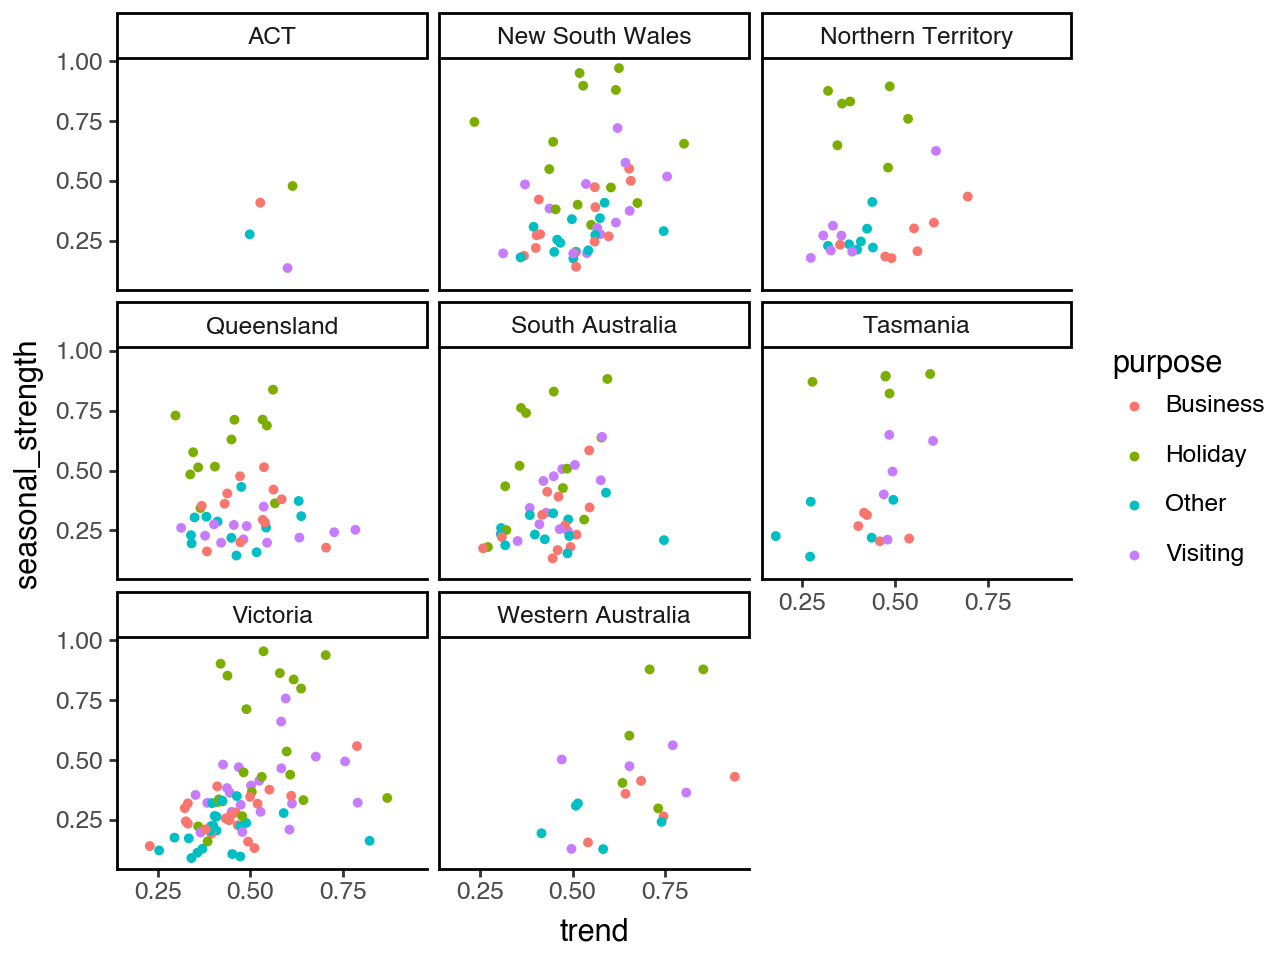

In [33]:
df_aus_tour = pd.read_csv("data/raw/aus_tourism.csv", parse_dates=["ds"])

stl_feat = tsfeatures(df_aus_tour, freq=4, features=[stl_features])
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split("-", expand=True)

(ggplot(data=stl_feat, mapping=aes(x='trend', y='seasonal_strength', group='purpose', color='purpose')) + 
    geom_point(size=1) + 
    facet_wrap(facets='~state') + 
    theme_classic())

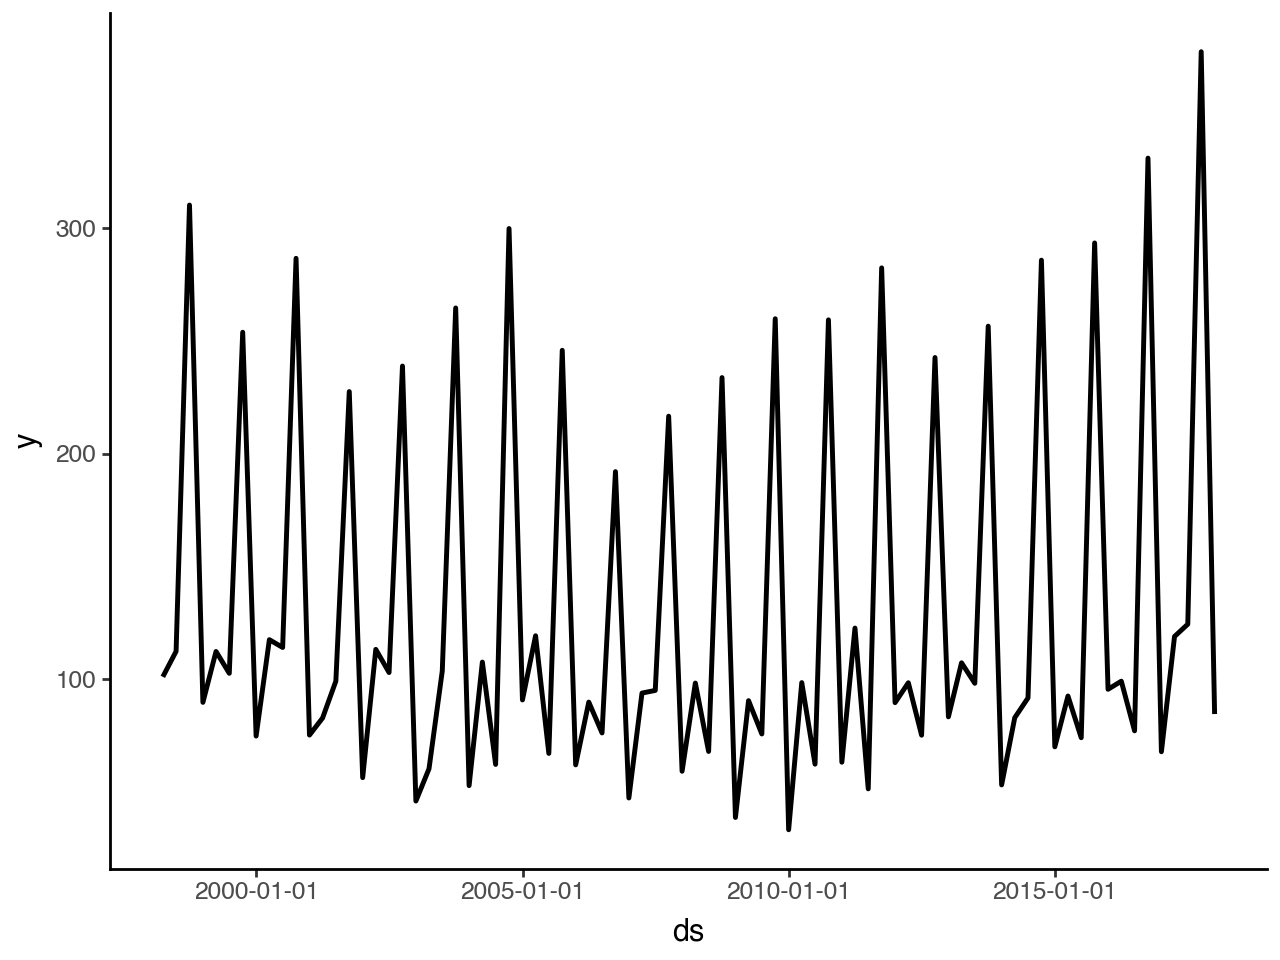

In [27]:
df_aus_tour = pd.read_csv("data/raw/aus_tourism.csv", parse_dates=["ds"])

max_seasonal_strength_row = stl_feat.loc[stl_feat["seasonal_strength"].idxmax()]

max_unique_id = max_seasonal_strength_row["unique_id"]

(ggplot(data=df_aus_tour.loc[df_aus_tour['unique_id'].eq(max_unique_id)], 
        mapping=aes(x='ds', y='y')) +
        geom_line(size=1) + 
        theme_classic())

Other features returned by `tsfeatures`: 

1. `hurst`: computes Hurst coefficient (measure of long memory). Series with long memory. 
2. `feat_spectral`: computes Shannon spectral entropy (measure of how easy it is to forecast). 
3. `box_pierce` gives Box-Pierce statistic for testing if a time series is white noise . 
4. `ljung-box` gives Ljung-Box statistic for testing if a time series is white 
5. `n_crossing_points`: computes number of times a time series crosses the median 
6. `stat_arch_lm` returnes Lagrange Multiplier (LM) test for autoregressive conditional heteroscedasticity 
7. `guerrero` computes optimal value for $\lambda$ for Box-Cox transformation. 

### 4.5. Exploring Ontarian gas prices

In [136]:
df_ontario_gas = pd.read_csv('data/processed/data_ontario_gas_all.csv', parse_dates=["Date"])
df_ontario_gas.rename(columns={'Date': 'ds', 
                               "price_2025": 'y'}, inplace=True)
# combine fuel type + city 
df_ontario_gas['unique_id'] = df_ontario_gas['Fuel Type'] + '_' + df_ontario_gas['city']

all_features = [acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp,
    series_length,
    hurst]

all_feat = tsfeatures(df_ontario_gas, freq=4, features=all_features)
all_feat[["fuel_type", "city"]] = all_feat["unique_id"].str.split("_", n=1, expand=True)


/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-packages/statsmo

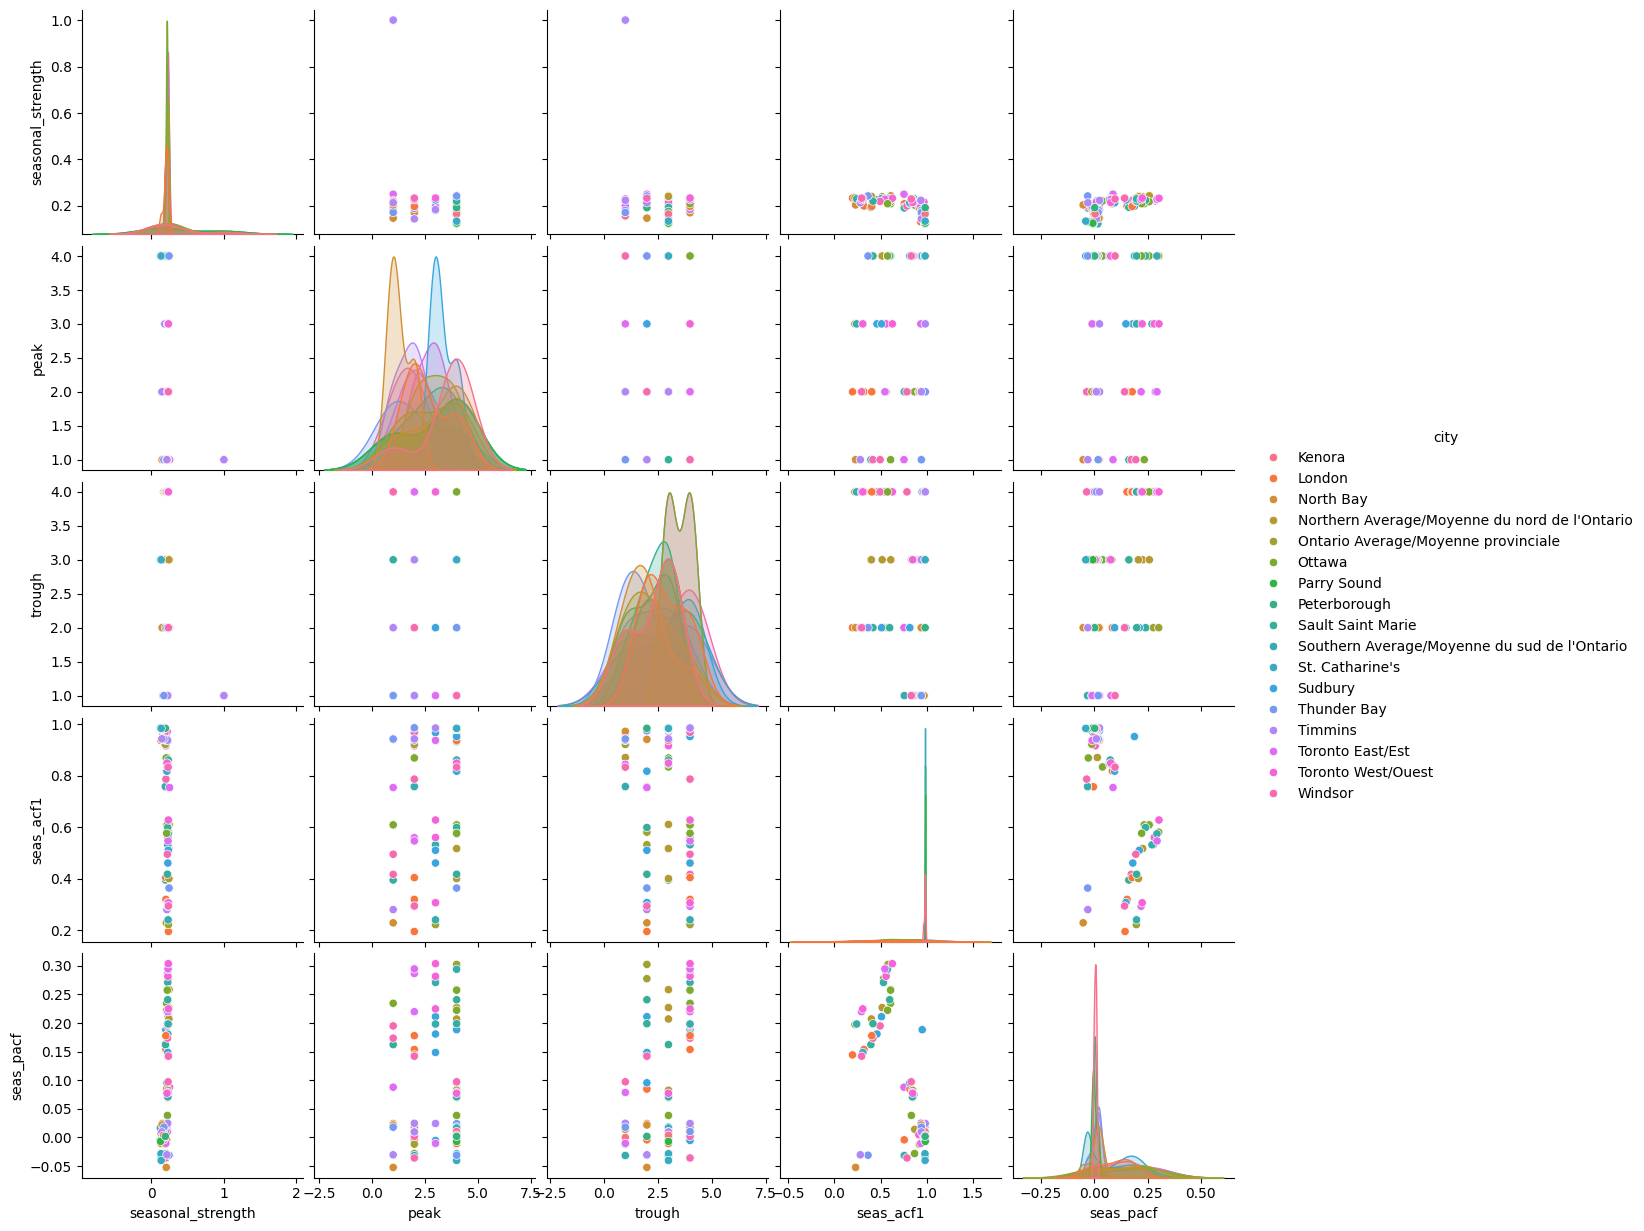

In [110]:
seasonal_feat = all_feat[["unique_id", "seasonal_strength", "peak", "trough", "seas_acf1", "seas_pacf"]].copy()
seasonal_feat[["fuel_type", "city"]] = seasonal_feat["unique_id"].str.split("_", n=1, expand=True)

g = sns.pairplot(seasonal_feat, hue="city")
plt.show()

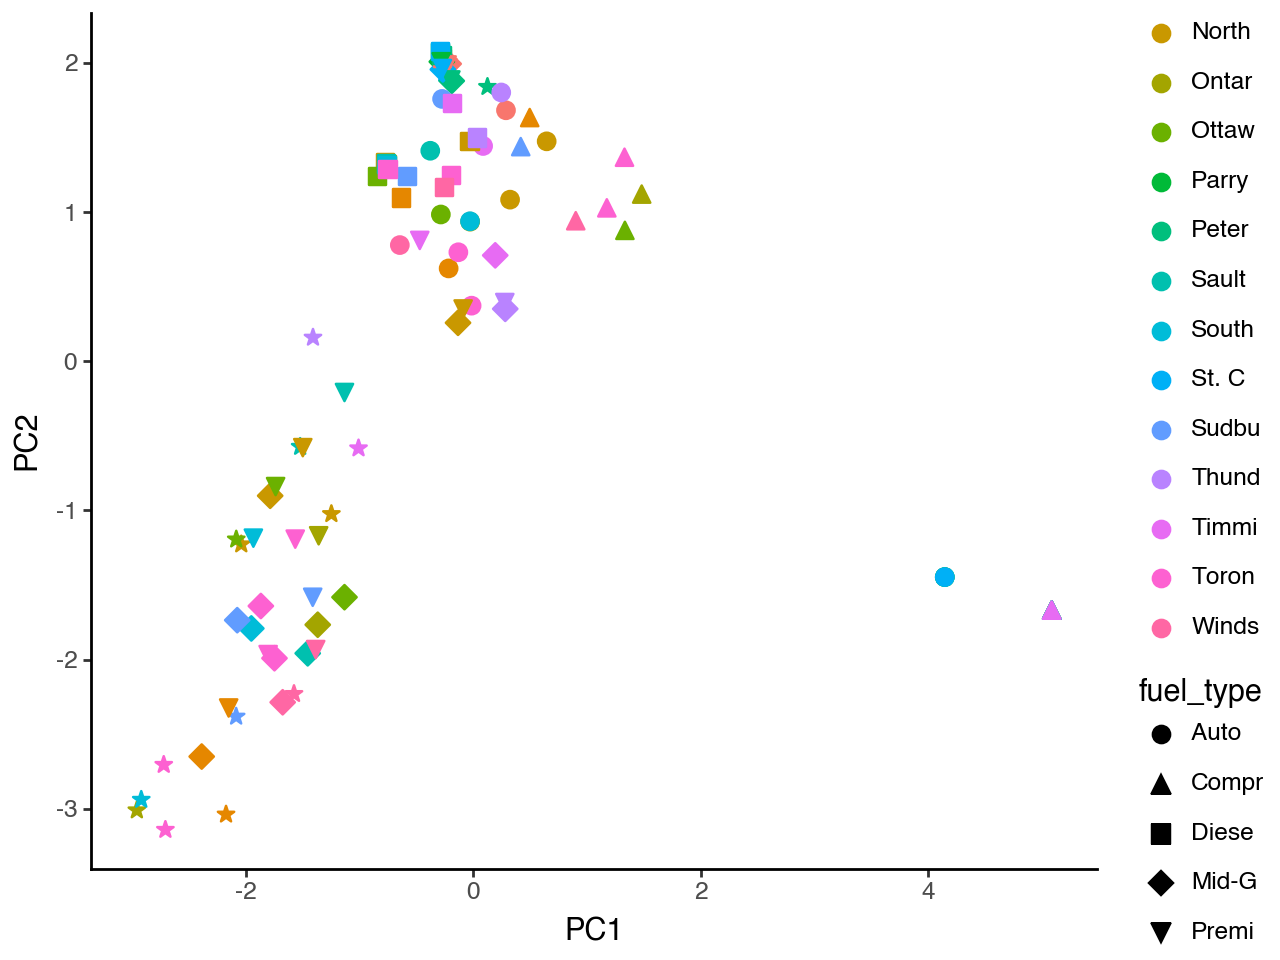

In [123]:
# Using PCA
features = all_feat.columns[all_feat.notna().all()].tolist()
exclude = ['unique_id', 'city', 'fuel_type']

features = [col for col in features if col not in exclude]


X = all_feat[features]
y = all_feat[["city","fuel_type"]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Plotting the first two PCA components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df[["city", "fuel_type"]] = y
pca_df["city"] = pca_df["city"].str.slice(0, 5)
pca_df["fuel_type"] = pca_df["fuel_type"].str.slice(0, 5)

(ggplot(data=pca_df, mapping=aes(x='PC1', y='PC2', color='city', shape='fuel_type')) + 
 geom_point(size=3) + 
 theme_classic()) 



In [144]:
# Time series plots fo St. Catherines Auto propane and Thunder Bay Compressed Natural Gas 
df_st_cath = df_ontario_gas.loc[df_ontario_gas['Fuel Type'].eq('Auto Propane') & 
                                df_ontario_gas['city'].eq("St. Catharine's")]
df_st_cath['y'].eq(0).sum()

df_thunder_bay = df_ontario_gas.loc[df_ontario_gas['Fuel Type'].eq('Compressed Natural Gas') & 
                                df_ontario_gas['city'].eq("Thunder Bay")]

df_thunder_bay['y'].eq(0).sum()



np.int64(1767)